In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_train = np.load('FireEvac_train_set.npy')
print(type(data_train))

<class 'numpy.ndarray'>


In [3]:
df_train = pd.DataFrame(data_train,columns = ['X-Coordinate','Y-Coordinate'])
df_train.head()

,X-Coordinate,Y-Coordinate
0,86.692627,62.442292
1,75.545682,78.160170
2,123.449519,85.437612
3,74.980185,81.212226
4,122.617385,71.400531


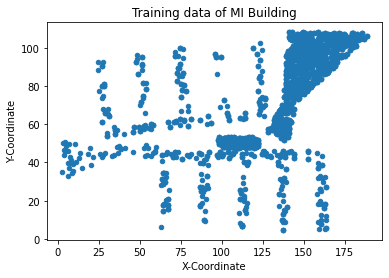

In [4]:
df_train.plot(kind = 'scatter',x='X-Coordinate',y='Y-Coordinate',title='Training data of MI Building')

In [5]:
data_test = np.load('FireEvac_test_set.npy')
print(type(data_test))

<class 'numpy.ndarray'>


In [6]:
df_test = pd.DataFrame(data_test,columns = ['X-Coordinate','Y-Coordinate'])
df_test.head()

,X-Coordinate,Y-Coordinate
0,79.233728,66.956408
1,27.604958,74.588816
2,53.205270,65.798210
3,124.299537,87.967949
4,76.150470,94.905859


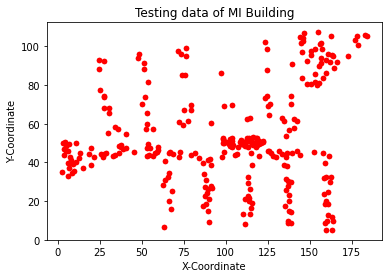

In [7]:
df_test.plot(kind = 'scatter',x='X-Coordinate',y='Y-Coordinate',title='Testing data of MI Building',color = 'red')

In [8]:
print(df_train.shape)
print(df_test.shape)

(3000, 2)
(600, 2)


In [9]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_set = scaler.fit_transform(df_train)
test_set = scaler.transform(df_test)
print(type(train_set))
print(type(test_set))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
df_train = pd.DataFrame(train_set,columns = ['X-Coordinate','Y-Coordinate'])
df_test = pd.DataFrame(test_set,columns = ['X-Coordinate','Y-Coordinate'])

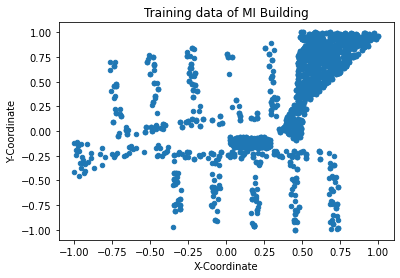

In [11]:
df_train.plot(kind = 'scatter',x='X-Coordinate',y='Y-Coordinate',title='Training data of MI Building')

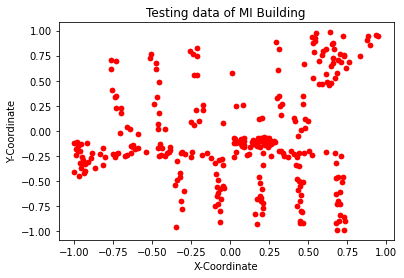

In [12]:
df_test.plot(kind = 'scatter',x='X-Coordinate',y='Y-Coordinate',title='Testing data of MI Building',color = 'red')

Setting up the Hyperparameters for training

In [13]:
epochs = 101
batch_size = 64
learning_rate = 0.001

In [14]:
import torch; torch.manual_seed(0)
from torch import nn
from torch.nn.functional import relu
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from itertools import cycle
from tqdm import tqdm


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cpu device


In [15]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=10):
        super(VariationalEncoder, self).__init__()

        self.linear1 = nn.Linear(2, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear_mu = nn.Linear(256, latent_dims)
        self.linear_sigma = nn.Linear(256, latent_dims)

        self.N = torch.distributions.Normal(torch.zeros(latent_dims), torch.ones(latent_dims))
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        mu = self.linear_mu(x)
        sigma = self.linear_sigma(x).exp()

        z = mu + sigma*self.N.sample()
        self.kl = 1/2 * (sigma**2 + mu**2 - torch.log(sigma ** 2) - 1).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims=10):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 2)
        self.sigma = nn.Parameter(torch.ones(1))

    def forward(self, z):
        z = relu(self.linear1(z))
        z = relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims=2):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [16]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    l = 0
    for batch, (X) in enumerate(dataloader):
        X = X.to(device)
        optimizer.zero_grad()

        pred = model(X)

        loss = loss_fn(X, pred.squeeze(), model.decoder.sigma, model.encoder.kl)
        l += loss.item()

        loss.backward()
        optimizer.step()
    
    l /= len(dataloader)
    return l

In [17]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(X, pred.squeeze(), model.decoder.sigma, model.encoder.kl).item()
    test_loss /= num_batches
    
    return test_loss

In [18]:
def elbo(X, mu, sigma, kl):
    return (torch.distributions.Normal(mu, sigma.exp()).log_prob(X.squeeze()).sum() - kl) / len(X)

def loss_fn(X, mu, sigma, kl):
    return -elbo(X, mu, sigma, kl)

In [19]:
def plot_latent(vae, dataloader, num_batches=100):
    plt.figure(figsize=(10, 10))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])
    
    for i, (x) in enumerate(dataloader):
        z = vae.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=next(colors))
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

def plot_reconstructed(vae, originals):
    fig, axes = plt.subplots(2, len(originals), figsize=(25, 5))
    
    for i in range(len(originals)):
        axes[1, i].imshow(vae(originals[i].to(device)).reshape(28, 28).to('cpu').detach().numpy())
        axes[0, i].imshow(originals[i].squeeze().numpy())
        
    plt.show()

def plot_generated(vae, samples):
    fig, axes = plt.subplots(1, len(samples), figsize=(25, 5))
    
    imgs = vae.decoder(samples.to(device)).reshape(len(samples), 28, 28).to('cpu').detach().numpy()
    
    for i in range(len(samples)):
        axes[i].imshow(imgs[i])
        axes[i].set_title(f"{samples[i][0].item():.1f}, {samples[i][1].item():.1f}")
        
    plt.show()

In [20]:
train_set = train_set.astype(np.float32)
test_set = test_set.astype(np.float32)

In [21]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(train_dataloader)

In [22]:
vae = VariationalAutoencoder(2).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
train_losses = []
val_losses = []


We are at Epoch 0
Current training loss is equal to:3.8216498303920665
Current testing loss is equal to:3.811232829093933
We are at Epoch 1
Current training loss is equal to:3.7271621379446476
Current testing loss is equal to:3.718131399154663
We are at Epoch 2
Current training loss is equal to:3.636264978571141
Current testing loss is equal to:3.632629919052124
We are at Epoch 3
Current training loss is equal to:3.545614186753618
Current testing loss is equal to:3.54714891910553
We are at Epoch 4
Current training loss is equal to:3.4555102206291037
Current testing loss is equal to:3.4702085971832277
We are at Epoch 5
Current training loss is equal to:3.3658349767644355
Current testing loss is equal to:3.3789363384246824
We are at Epoch 6
Current training loss is equal to:3.2771251708903213
Current testing loss is equal to:3.2934147119522095
We are at Epoch 7
Current training loss is equal to:3.1884688062870756
Current testing loss is equal to:3.2091740131378175
We are at Epoch 8
Curre

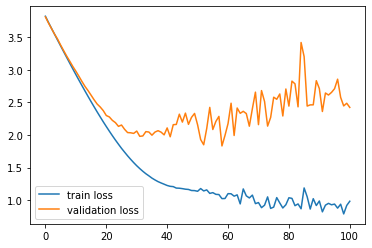

In [23]:
for epoch in range(epochs):
    train_losses.append(train_one_epoch(train_dataloader, vae, loss_fn, optimizer))
    val_losses.append(test(val_dataloader, vae, loss_fn))
    print("We are at Epoch {}".format(epoch))
    print("Current training loss is equal to:{}".format(train_losses[epoch]))
    print("Current testing loss is equal to:{}".format(val_losses[epoch]))
    



plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()



     


In [24]:
def reconstruct(model, dataloader):
    model.eval()
    reconstruction_result = []
    for i, data in enumerate(dataloader):
        reconstruction_result.append(model(data.view(data.size(0), -1)).detach())

    return reconstruction_result

In [25]:
reconstruction_test = reconstruct(vae, val_dataloader)
reconstruction_train = reconstruct(vae, train_dataloader)

In [26]:
def detach_tensor(dataset):
  detached_result = []
  for tensor in dataset:
    detached_result.append(scaler.inverse_transform(tensor.detach()))
  return detached_result


In [27]:
detached_train = detach_tensor(reconstruction_train)
detached_test = detach_tensor(reconstruction_test)

In [28]:
detached_test = detach_tensor(reconstruction_test)

In [29]:
print(len(detached_train))
print(len(detached_test))

47
10


In [30]:
def visualize_mi_evacuation(dataset):
  for arr in dataset:
    plt.scatter(x = arr[:,0],y = arr[:,1])



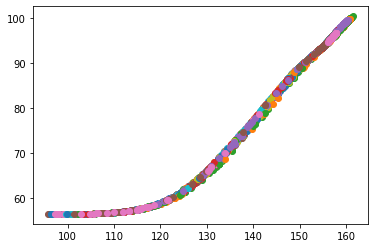

In [31]:
visualize_mi_evacuation(detached_train)


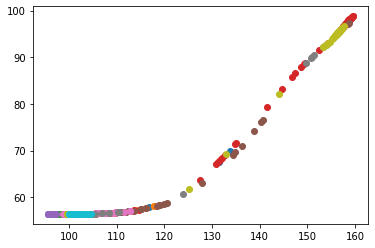

In [32]:
visualize_mi_evacuation(detached_test)